In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-08-26 08:10:11.203621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756195811.395103      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756195811.448475      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Update with your Kaggle dataset paths
train_dir = '/kaggle/input/reduced-dataset20k26/Train'
val_dir   = '/kaggle/input/reduced-dataset20k26/Validation'
test_dir  = '/kaggle/input/reduced-dataset20k26/Test'


In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(299, 299),
                                                    batch_size=32,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(299, 299),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  shuffle=False)


Found 20000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
# Load InceptionV3 without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom classification head with dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)       # Dropout 1
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)       # Changed from 0.3 → 0.5
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


In [7]:
# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Training Top Layers (Transfer Learning) ---")
history_transfer = model.fit(train_generator,
                             epochs=10,
                             validation_data=val_generator)



--- Training Top Layers (Transfer Learning) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1756196007.645772     116 service.cc:148] XLA service 0x7bb74c003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756196007.646765     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756196009.740205     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/625 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.5625 - loss: 0.7359   

I0000 00:00:1756196018.250075     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 522s 799ms/step - accuracy: 0.5843 - loss: 0.6953 - val_accuracy: 0.7401 - val_loss: 0.5526
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 428s 686ms/step - accuracy: 0.6809 - loss: 0.5948 - val_accuracy: 0.7538 - val_loss: 0.5157
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 421s 674ms/step - accuracy: 0.7020 - loss: 0.5695 - val_accuracy: 0.7620 - val_loss: 0.5104
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 417s 667ms/step - accuracy: 0.7141 - loss: 0.5570 - val_accuracy: 0.7655 - val_loss: 0.5006
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 418s 669ms/step - accuracy: 0.7125 - loss: 0.5577 - val_accuracy: 0.7506 - val_loss: 0.5031
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 413s 660ms/step - accuracy: 0.7124 - loss: 0.5488 - val_accuracy: 0.7685 - val_loss: 0.4963
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 415s 664ms/step - accuracy: 0.7287 - loss: 0.5394 - val_accuracy: 0.7739 - val_loss: 0.4902
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 431s 690ms/step - accuracy: 0.7300 - loss: 0.53

In [8]:
# Unfreeze top 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n--- Fine-Tuning Last 50 Layers ---")
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    callbacks=[early_stop])
      


--- Fine-Tuning Last 50 Layers ---
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 478s 724ms/step - accuracy: 0.7303 - loss: 0.5340 - val_accuracy: 0.8111 - val_loss: 0.4142
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 440s 704ms/step - accuracy: 0.8205 - loss: 0.4007 - val_accuracy: 0.8468 - val_loss: 0.3488
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 431s 689ms/step - accuracy: 0.8627 - loss: 0.3198 - val_accuracy: 0.8686 - val_loss: 0.3067
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 419s 670ms/step - accuracy: 0.8948 - loss: 0.2620 - val_accuracy: 0.8752 - val_loss: 0.2902
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 416s 666ms/step - accuracy: 0.9029 - loss: 0.2418 - val_accuracy: 0.8824 - val_loss: 0.2773
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 416s 666ms/step - accuracy: 0.9187 - loss: 0.2022 - val_accuracy: 0.8826 - val_loss: 0.2737
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 418s 669ms/step - accuracy: 0.9220 - loss: 0.1960 - val_accuracy: 0.8947 - val_loss: 0.2555
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
def combine_history(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

history_final = combine_history(history_transfer, history)


In [10]:
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc     = model.evaluate(val_generator, verbose=0)
test_loss, test_acc   = model.evaluate(test_generator, verbose=0)

print("\n--- Final Accuracy & Loss ---")
print(f"Train Accuracy:      {train_acc:.4f} | Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f}")
print(f"Test Accuracy:       {test_acc:.4f} | Loss: {test_loss:.4f}")



--- Final Accuracy & Loss ---
Train Accuracy:      0.9638 | Loss: 0.0959
Validation Accuracy: 0.9035 | Loss: 0.2494
Test Accuracy:       0.8200 | Loss: 0.4758


In [11]:
# Predictions on test data
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32")
y_true = test_generator.classes

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- Precision / Recall / F1 ---")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 169ms/step

--- Precision / Recall / F1 ---
Precision: 0.8396
Recall:    0.7912
F1 Score:  0.8147


In [ ]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import cv2

explainer = lime.lime_image.LimeImageExplainer()

# Pick one real and one fake image from test set
real_img_path = test_generator.filepaths[y_true.tolist().index(0)]
fake_img_path = test_generator.filepaths[y_true.tolist().index(1)]

def explain_image(img_path, label_name):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))
    img_array = np.expand_dims(preprocess_input(img.astype(np.float32)), axis=0)

    explanation = explainer.explain_instance(img.astype('double'),
                                             model.predict,
                                             top_labels=1,
                                             hide_color=0,
                                             num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for {label_name}")
    plt.axis("off")
    plt.show()

# Explain real and fake
explain_image(real_img_path, "Real Image")
explain_image(fake_img_path, "Fake Image")


In [4]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(299, 299),
                                                    batch_size=32,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(299, 299),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 20000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 5500 images belonging to 2 classes.


In [5]:
# --- Load InceptionV3 base model ---
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# --- Add custom classification head with dropout ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)                       # Dropout to reduce overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

I0000 00:00:1754032650.183407      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Phase 1: Transfer Learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Training Top Layers (Transfer Learning) ---")
history_transfer = model.fit(train_generator,
                             epochs=10,  # You can do 10 here
                             validation_data=val_generator)



--- Training Top Layers (Transfer Learning) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1754032669.369377     113 service.cc:148] XLA service 0x7baa40459db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754032669.370184     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754032671.700480     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.6250 - loss: 0.6471   

I0000 00:00:1754032680.768103     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 554s 848ms/step - accuracy: 0.6116 - loss: 0.6682 - val_accuracy: 0.7436 - val_loss: 0.5205
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 458s 732ms/step - accuracy: 0.6945 - loss: 0.5801 - val_accuracy: 0.7549 - val_loss: 0.5014
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 731ms/step - accuracy: 0.7182 - loss: 0.5545 - val_accuracy: 0.7514 - val_loss: 0.5046
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 472s 755ms/step - accuracy: 0.7239 - loss: 0.5438 - val_accuracy: 0.7573 - val_loss: 0.5011
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 480s 768ms/step - accuracy: 0.7184 - loss: 0.5437 - val_accuracy: 0.7641 - val_loss: 0.4833
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 463s 741ms/step - accuracy: 0.7318 - loss: 0.5332 - val_accuracy: 0.7646 - val_loss: 0.4928
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 732ms/step - accuracy: 0.7335 - loss: 0.5280 - val_accuracy: 0.7661 - val_loss: 0.4928
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 463s 740ms/step - accuracy: 0.7295 - loss: 0.53

In [7]:
# --- Fine-Tuning Phase: unfreeze top 50 layers ---
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Fine-Tuning Last 50 Layers ---")
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)



--- Fine-Tuning Last 50 Layers ---
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 504s 757ms/step - accuracy: 0.7267 - loss: 0.5406 - val_accuracy: 0.8115 - val_loss: 0.4137
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 468s 749ms/step - accuracy: 0.8180 - loss: 0.4001 - val_accuracy: 0.8440 - val_loss: 0.3527
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 449s 718ms/step - accuracy: 0.8583 - loss: 0.3259 - val_accuracy: 0.8644 - val_loss: 0.3152
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 731ms/step - accuracy: 0.8908 - loss: 0.2668 - val_accuracy: 0.8729 - val_loss: 0.2902
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 468s 749ms/step - accuracy: 0.9060 - loss: 0.2369 - val_accuracy: 0.8820 - val_loss: 0.2825
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 466s 745ms/step - accuracy: 0.9145 - loss: 0.2151 - val_accuracy: 0.8840 - val_loss: 0.2786
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 461s 738ms/step - accuracy: 0.9269 - loss: 0.1809 - val_accuracy: 0.8873 - val_loss: 0.2769
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
#%%
# --- Combine Training History ---
def combine_history(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history
history_final = combine_history(history_transfer, history)

In [9]:
# --- Evaluate Final Model ---
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# --- Print Results ---
print("\n--- Final Accuracy & Loss ---")
print(f"Train Accuracy:      {train_acc:.4f} | Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}   | Loss: {val_loss:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}   | Loss: {test_loss:.4f}")


--- Final Accuracy & Loss ---
Train Accuracy:      0.9674 | Loss: 0.0874
Validation Accuracy: 0.9015   | Loss: 0.2576
Test Accuracy:       0.8024   | Loss: 0.5741


In [12]:
# Predictions on test data
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32")
y_true = test_generator.classes

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n--- Precision / Recall / F1 ---")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step

--- Precision / Recall / F1 ---
Precision: 0.8396
Recall:    0.7912
F1 Score:  0.8147


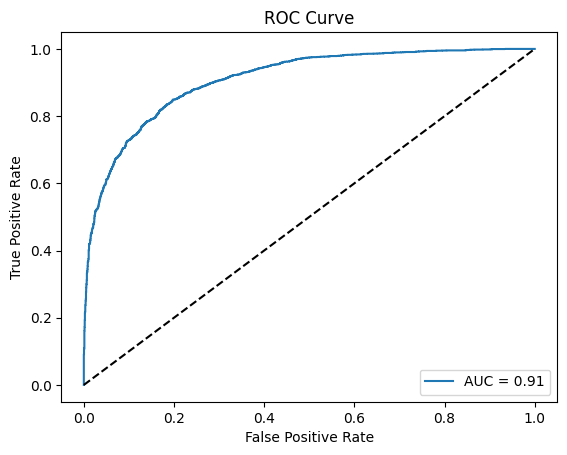

In [13]:
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━

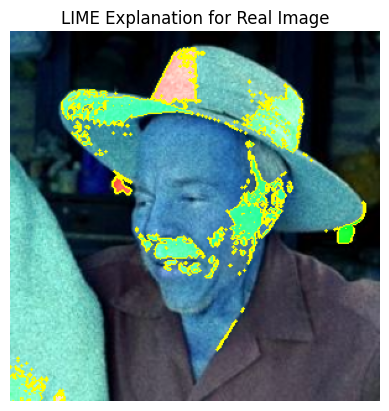

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

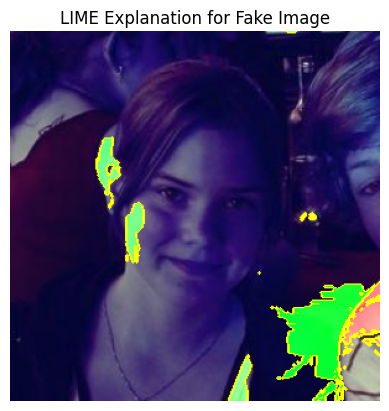

In [14]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import cv2

explainer = lime.lime_image.LimeImageExplainer()

# Pick one real and one fake image from test set
real_img_path = test_generator.filepaths[y_true.tolist().index(0)]
fake_img_path = test_generator.filepaths[y_true.tolist().index(1)]

def explain_image(img_path, label_name):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (299, 299))
    img_array = np.expand_dims(preprocess_input(img.astype(np.float32)), axis=0)

    explanation = explainer.explain_instance(img.astype('double'),
                                             model.predict,
                                             top_labels=1,
                                             hide_color=0,
                                             num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for {label_name}")
    plt.axis("off")
    plt.show()

# Explain real and fake
explain_image(real_img_path, "Real Image")
explain_image(fake_img_path, "Fake Image")
